!! Note: Provide argument and the model runs at 3. Run all cells above it to perform

In [1]:
import keras
import numpy as np
from keras.applications import VGG19, VGG16
from keras import backend as K
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf


Using TensorFlow backend.
/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Loss functions

In [2]:
#we use this because the original and generate is tensors, not numpy
def content_loss(original,generate):
    return 1/2 * K.sum(K.square(generate-original))
  
  #style loss
def gram_matrix(F):
    """
    input:
        F: response of a layler L
    output:
        gram matrix of F
    """
    shape = K.int_shape(F)
    F_new = K.reshape(F,(int(shape[0]*shape[1]),shape[2]))
    F_t = K.transpose(F_new)
    return K.dot(F_t,F_new)
  
def layer_style_loss(original,generate):
    """
      input:
          - original: original normalized image
          - generate: the output of ONE layer
      output: 
          - the style loss compute of this layer E_l
    """
    A = gram_matrix(original)
    G = gram_matrix(generate)
    shape = K.int_shape(original)
    M = K.constant(int(shape[0]*shape[1]))
    N = K.constant(shape[2])
    E = K.sum(K.square(A-G))/(4*(N**2)*(M**2))
    return E



# Style transfer model

In [3]:
"""
Loss and gradient evaluator to pass into bfgs algorithm from scipy
Tried VGG16, alpha/beta ratio small and alpha < 1=> good result, arguably better and less noise than vgg19
"""
class Eval:
    def __init__(self,func,image_size):
        self.func = func
        self.image_size = image_size
    def eval_loss(self,X):
        X = X.reshape(self.image_size)
        outputs = self.func([X])
        loss = outputs[0]
        self._grad = outputs[1].flatten().astype("float64")
        return loss
    def eval_grad(self,X):
        return self._grad
"""
Model to perform style transfer, according to Gatsy et al:
- content layer = block4_conv2
- style layer = blocki_conv1 for i = 1 to 5

"""

class StyleTransfer():
    def __init__(self, 
               content_layer = 'block2_conv2',
               style_layer = ['block1_conv2','block2_conv2','block3_conv3'
                              ,'block4_conv3','block5_conv3'],
               content_weight = 0.0,
               style_layer_weights = [],
               style_weight = 0.0
               ):
        self.content_layer = content_layer
        self.style_layer = style_layer
        self.content_weight = content_weight
        self.style_layer_weights = style_layer_weights
        self.style_weight = style_weight
  
    def load_image(self,content_img_path = None, style_img_path=None,image_size = None):
        #Load and resize to appropriate shapes
        content_img = Image.open(content_img_path)
        if image_size is not None:
            content_img = content_img.resize(image_size)
        image_size = content_img.size
        style_img = Image.open(style_img_path).resize(image_size)
#         print("load content image")
#         content.show()
#         print("load style image resized")
#         style.show()
    
        #convert to matrix
        #Turns into a 3D matrix of height x width x channel (RGB)
        content, style = np.asarray(content_img,dtype=np.float32),np.asarray(style_img,dtype=np.float32)
        #Expand dim along axis 0, so turn into a 4D array of frame x height x width x channel
        #frame here = 1, this serves to concat the images later on
        content, style = np.expand_dims(content,axis=0), np.expand_dims(style,axis=0)

        #Normalize
        #Imagenet RGB or BGR <?> means
        imagenet_means = np.array([123.68, 116.779, 103.939])
        #normalize
        for i in range(imagenet_means.shape[0]):
            l = imagenet_means.shape[0] - 1
            content[:,:,:,i] -= imagenet_means[l-i]
            style[:,:,:,i] -= imagenet_means[l-i]
        #Flip from RGB to BGR
        content, style = content[:,:,:,::-1], style[:,:,:,::-1]
        return content, style

    
    
    def build_model(self, content, style):
        """
        content: content image as a matrix/tensor after processing
        style: style image as a matrix/tensor after processing
        returns: constructed VGG19 model and combination tensor
        """
        content_matrix, style_matrix = K.variable(content), K.variable(style)
        combination = K.placeholder(content.shape)
        model = VGG16(input_tensor=K.concatenate([content_matrix,style_matrix,combination],axis=0),
                      include_top=False, pooling='avg')
        return model, combination
  
    def loss_grads_func(self,model,combination):
        """
        Build a function to calculate loss + gradients from an input X
        """

        loss = K.variable(0.0)
        layer_output = {layer.name: layer.output for layer in model.layers}
        content_output = layer_output[self.content_layer]
        style_outputs = [layer_output[layer] for layer in self.style_layer]
        
        #Compute total loss
        # Content loss = difference between output of content image and white noise image
        loss = loss + self.content_weight*content_loss(content_output[0],content_output[2])
        tmp = K.variable(0.0)
        for output, wl in zip(style_outputs,self.style_layer_weights):
            tmp = tmp + wl*layer_style_loss(output[1],output[2])
        loss = loss + self.style_weight*tmp
        

        #Calc gradients, only need wrt the input (combination image)
        grads = K.gradients(loss,combination)[0]
        return K.function([combination],[loss,grads])

  
    def train(self,
           content_path=None,
           style_path=None,
           iterations = 10,
           image_size = None,
           max_evaluations = 20,
           verbose = 1
           ):
        #Init
        K.clear_session()
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.25
        sess = tf.Session(config=config)
        set_session(sess)
        content, style = self.load_image(content_path, style_path,image_size)
        model, combination = self.build_model(content,style)
        
        f = self.loss_grads_func(model,combination)
        # actual white noise input to optimize
        #print(combination.shape)
        combination_image = np.random.uniform(0,1,combination.shape)
        #Evaluate the actual value of loss and grad 
        evaluator = Eval(f,combination.shape)
        for i in range(iterations):
#             print("Iteration %d" % i)
          #need to flatten combination image when passing in?
            combination_image, loss_val, info = fmin_l_bfgs_b(evaluator.eval_loss,
                                                        combination_image,
                                                        fprime=evaluator.eval_grad,
                                                        maxfun = max_evaluations
                                                       )
            if verbose:
                print("Iteration {}: loss {}".format(i,loss_val))

        #Denormalize and return output image
        #BGR mean
        combination_image = combination_image.reshape(combination.shape)[0]
        #imagenet_means = np.array([103.939, 116.779, 123.68])
#         for i in range(imagenet_means.shape[0]):
#             combination_image[:,:,:,i] += imagenet_means[i]

#         #Flip back from BGR to RGB
#         combination_image = combination_image[:,:,:,::-1]
        return combination_image
    

# Run the model


To run the model, please enter the path of the image you want to change style to content_path 

Choose the style image in style_path

## Model specification (ENTER IMAGE PATH HERE)


To run the model, please enter the path of the image you want to change style to content_path

Choose the style image in style_path

In [18]:
content_path = "mountain.jpg"
style_path="the-starry-night.jpg"
IMAGE_WIDTH, IMAGE_HEIGHT = 256,256
image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
content_weight, style_weight = 0.1, 5e3


## Run

In [14]:
Sty = StyleTransfer(content_weight = 0.1,style_layer_weights = [0.2,0.2,0.2,0.2,0.2],style_weight = 5e3)

In [17]:
%time output_img = Sty.train(content_path = content_path, style_path=style_path,image_size = image_size,iterations = 20)


Iteration 0: loss 325165809664.0
Iteration 1: loss 85640601600.0
Iteration 2: loss 58709250048.0
Iteration 3: loss 48325099520.0
Iteration 4: loss 43722846208.0
Iteration 5: loss 40098377728.0
Iteration 6: loss 37588160512.0
Iteration 7: loss 35658514432.0
Iteration 8: loss 34067838976.0
Iteration 9: loss 32988782592.0
Iteration 10: loss 32030578688.0
Iteration 11: loss 31284977664.0
Iteration 12: loss 30361491456.0
Iteration 13: loss 29659492352.0
Iteration 14: loss 29090877440.0
Iteration 15: loss 28645863424.0
Iteration 16: loss 28300568576.0
Iteration 17: loss 27890626560.0
Iteration 18: loss 27509250048.0
Iteration 19: loss 27179722752.0
CPU times: user 2min 14s, sys: 14.2 s, total: 2min 28s
Wall time: 27.8 s


Running for 1 image of 256*256 for 20 iterations takes 2min 14s


Running for 1 image of 500*500 for 20 iterations takes 6 min 58s

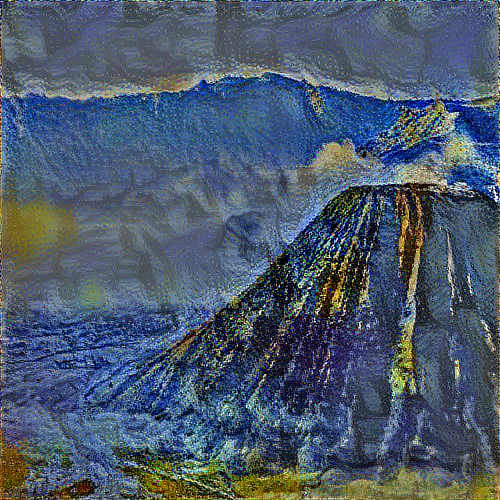

In [12]:
x = output_img.copy()
IMAGENET_MEANS = np.array([123.68, 116.779, 103.939])
x = x[:, :, ::-1]
for i in range(IMAGENET_MEANS.shape[0]):
    l = IMAGENET_MEANS.shape[0] - 1
    x[:,:,i] += IMAGENET_MEANS[l-i]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
c = content_path.split('.')[0]
s = style_path.split('.')[0]


#save the name of the image
out_path = "styled_{}_{}_.jpg".format(c,s)
output_image.save(out_path)
output_image

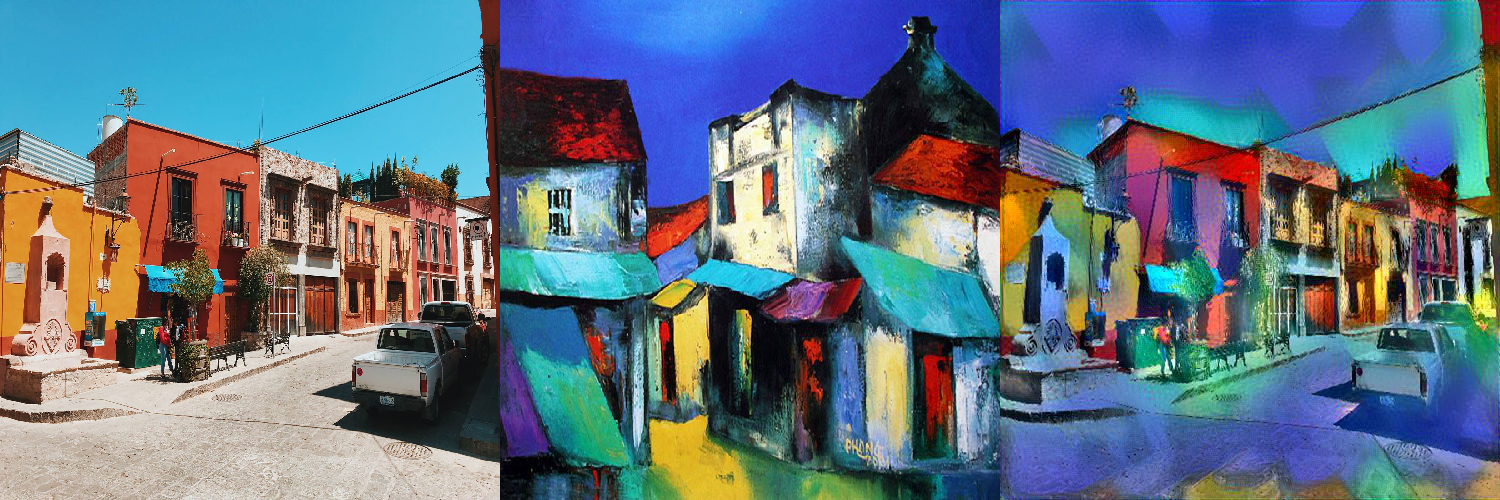

In [42]:
#produce overview image
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
combined_path = "combined_{}_{}_{}_{}.jpg".format(c,s,content_weight,style_weight)
x_offset = 0
for image in map(Image.open, [content_path, style_path, out_path]):
    image = image.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_path)
combined

## Reconstruction

In [4]:
class Eval:
    def __init__(self,func,image_size):
        self.func = func
        self.image_size = image_size
    def eval_loss(self,X):
        X = X.reshape(self.image_size)
        outputs = self.func([X])
        loss = outputs[0]
        self._grad = outputs[1].flatten().astype("float64")
        return loss
    def eval_grad(self,X):
        return self._grad

class Reconstructor():
    def load_image(self,img_path = None,image_size = None):
        img = Image.open(img_path)
        if image_size is not None:
            img = img.resize(image_size)
        im = np.asarray(img,dtype=np.float32)
        im = np.expand_dims(im,axis=0)

        #Normalize
        #Imagenet RGB or BGR <?> means
        imagenet_means = np.array([123.68, 116.779, 103.939])
        #normalize
        for i in range(imagenet_means.shape[0]):
            l = imagenet_means.shape[0] - 1
            im[:,:,:,i] -= imagenet_means[l-i]
        im = im[:,:,:,::-1]
        return im

    
    
    def build_model(self, image):
        """
        content: content image as a matrix/tensor after processing
        style: style image as a matrix/tensor after processing
        returns: constructed VGG19 model and combination tensor
        """
        image_matrix = K.variable(image)
        combination = K.placeholder(image.shape)
        model = VGG16(input_tensor=K.concatenate([image_matrix,combination],axis=0),
                      include_top=False, pooling='avg')
        return model, combination
  
    def loss_grads_func_content(self,model,combination):
        """
        Build a function to calculate loss + gradients from an input X
        """

        loss = K.variable(0.0)
        layer_output = {layer.name: layer.output for layer in model.layers}
        content_output = layer_output[self.content_layer]
        
        loss = loss + content_loss(content_output[0],content_output[1])
        #Calc gradients, only need wrt the input (combination image)
        grads = K.gradients(loss,combination)[0]
        return K.function([combination],[loss,grads])
    
    def loss_grads_func_style(self,model,combination):
        """
        Build a function to calculate loss + gradients from an input X
        """

        loss = K.variable(0.0)
        layer_output = {layer.name: layer.output for layer in model.layers}
        style_outputs = [layer_output[layer] for layer in self.style_layer]
        
        #Compute total loss
        # Content loss = difference between output of content image and white noise image
        tmp = K.variable(0.0)
        for output, wl in zip(style_outputs,self.style_layer_weights):
            tmp = tmp + wl*layer_style_loss(output[0],output[1])
        loss = loss + tmp
        

        #Calc gradients, only need wrt the input (combination image)
        grads = K.gradients(loss,combination)[0]
        return K.function([combination],[loss,grads])

  
    def reconstruct_content(self,
           content_layer = None,
           content_path=None,
           iterations = 10,
           image_size = None,
           max_evaluations = 20,
           verbose = 0
           ):
        #Init
        K.clear_session()
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.25
        sess = tf.Session(config=config)
        set_session(sess)
        self.content_layer = content_layer
        content = self.load_image(content_path, image_size)
        model, combination = self.build_model(content)
        
        f = self.loss_grads_func_content(model,combination)
        # actual white noise input to optimize
        #print(combination.shape)
        combination_image = np.random.uniform(0,1,combination.shape)
        #Evaluate the actual value of loss and grad 
        evaluator = Eval(f,combination.shape)
        for i in range(iterations):
            combination_image, loss_val, info = fmin_l_bfgs_b(evaluator.eval_loss,
                                                        combination_image,
                                                        fprime=evaluator.eval_grad,
                                                        maxfun = max_evaluations
                                                       )
            if verbose:
                print("Iteration {}: loss {}".format(i,loss_val))

        #Denormalize and return output image
        #BGR mean
        del evaluator
        del f
        combination_image = combination_image.reshape(combination.shape)[0]
        return combination_image
    
    def reconstruct_style(self,
           style_layer = None,
           style_layer_weights = [],
           style_path=None,
           iterations = 10,
           image_size = None,
           max_evaluations = 20,
           verbose = 0
           ):
        #Init
        K.clear_session()
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.25
        sess = tf.Session(config=config)
        set_session(sess)
        self.style_layer = style_layer
        self.style_layer_weights = style_layer_weights
        style = self.load_image(style_path, image_size)
        model, combination = self.build_model(style)
        
        f = self.loss_grads_func_style(model,combination)
        # actual white noise input to optimize
        #print(combination.shape)
        combination_image = np.random.uniform(0,1,combination.shape)
        #Evaluate the actual value of loss and grad 
        evaluator = Eval(f,combination.shape)
        for i in range(iterations):
            combination_image, loss_val, info = fmin_l_bfgs_b(evaluator.eval_loss,
                                                        combination_image,
                                                        fprime=evaluator.eval_grad,
                                                        maxfun = max_evaluations
                                                       )
            if verbose:
                print("Iteration {}: loss {}".format(i,loss_val))

        #Denormalize and return output image
        #BGR mean
        del evaluator
        del f
        combination_image = combination_image.reshape(combination.shape)[0]
        return combination_image

In [17]:
del re

In [5]:
re = Reconstructor()

### Content Reconstruction

In [7]:
img = Image.open(content_path)
if image_size is not None:
    img = img.resize(image_size)
img.save("./reconstructed/original_content.jpg")

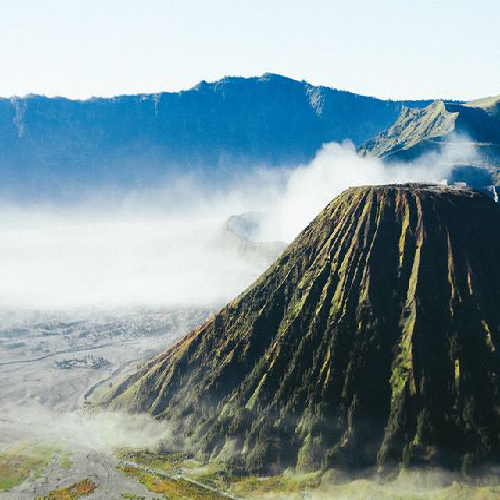

In [8]:
img

In [35]:
content_layers = ['block1_conv2','block3_conv2','block5_conv2']
outs = []
for content_layer in content_layers:
    out_img = re.reconstruct_content(content_layer = content_layer,
                                     content_path=content_path,
                                     iterations = 10,
                                     image_size = image_size,
                                     max_evaluations = 20,
                                     verbose = 0)
    x = out_img.copy()
    IMAGENET_MEANS = np.array([123.68, 116.779, 103.939])
    x = x[:, :, ::-1]
    for i in range(IMAGENET_MEANS.shape[0]):
        l = IMAGENET_MEANS.shape[0] - 1
        x[:,:,i] += IMAGENET_MEANS[l-i]
    x = np.clip(x, 0, 255).astype("uint8")
    output_image = Image.fromarray(x)
    out_path = "./reconstructed/reconstruct_content_{}.jpg".format(content_layer)
    outs.append(out_path)
    output_image.save(out_path)

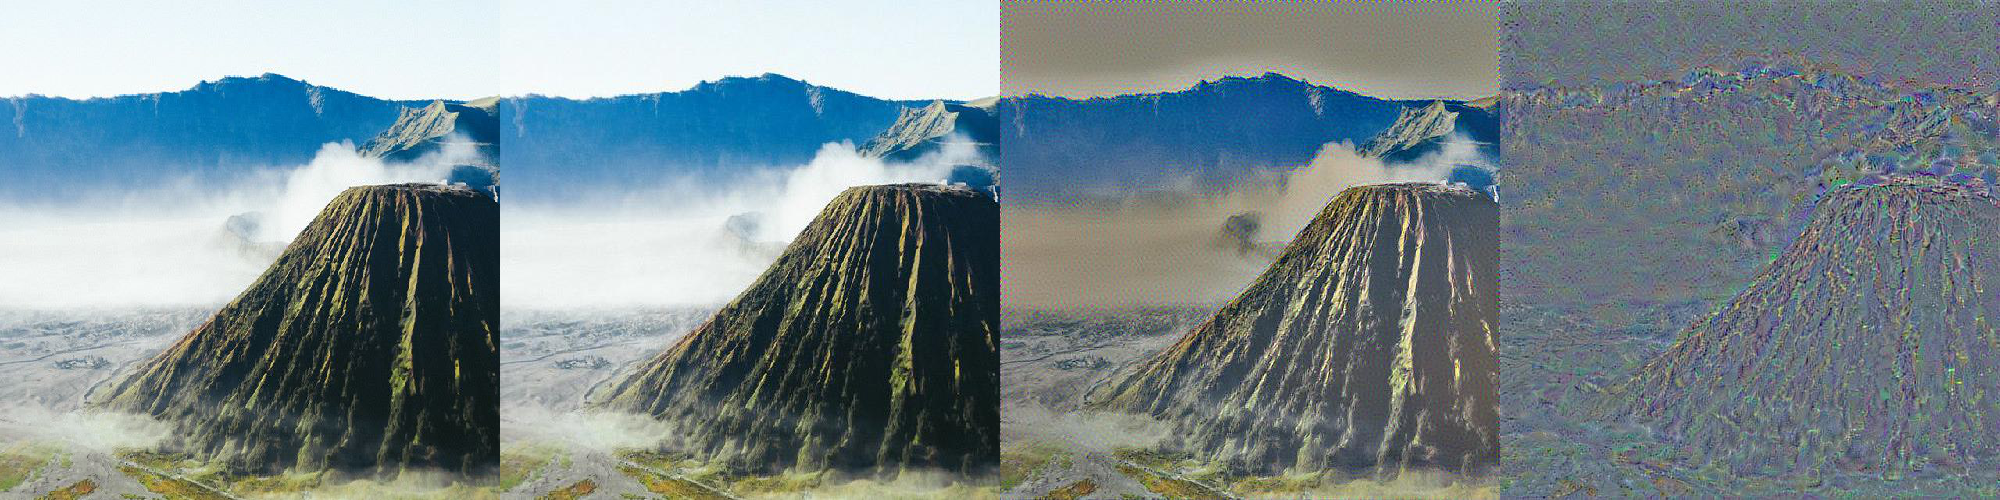

In [36]:
combined = Image.new("RGB", (IMAGE_WIDTH*4, IMAGE_HEIGHT))
combined_path = "content_reconstruct.jpg"
x_offset = 0
for image in map(Image.open, [content_path]+outs):
    image = image.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_path)
combined

### Style construction

In [33]:
#'block1_conv2','block2_conv2','block3_conv3'
#                              ,'block4_conv3','block5_conv3'

In [38]:
style_layers = [['block1_conv2'],['block1_conv2','block2_conv2'],['block1_conv2','block2_conv2','block3_conv3','block4_conv3','block5_conv3']]
outs = []
for style_layer in style_layers:
    re = Reconstructor()
    style_layer_weights = [1/(len(style_layer))]*len(style_layer)
    print(style_layer_weights)
    out_img = re.reconstruct_style(style_layer = style_layer,
                                   style_layer_weights = style_layer_weights,
                                   style_path=style_path,
                                   iterations = 10,
                                   image_size = image_size,
                                   max_evaluations = 20,
                                   verbose = 0)
    x = out_img.copy()
    IMAGENET_MEANS = np.array([123.68, 116.779, 103.939])
    x = x[:, :, ::-1]
    for i in range(IMAGENET_MEANS.shape[0]):
        l = IMAGENET_MEANS.shape[0] - 1
        x[:,:,i] += IMAGENET_MEANS[l-i]
    x = np.clip(x, 0, 255).astype("uint8")
    output_image = Image.fromarray(x)
    out_path = "./reconstructed/{}.jpg".format(style_layer)
    outs.append(out_path)
    output_image.save(out_path)
    del re

[1.0]
[0.5, 0.5]
[0.2, 0.2, 0.2, 0.2, 0.2]


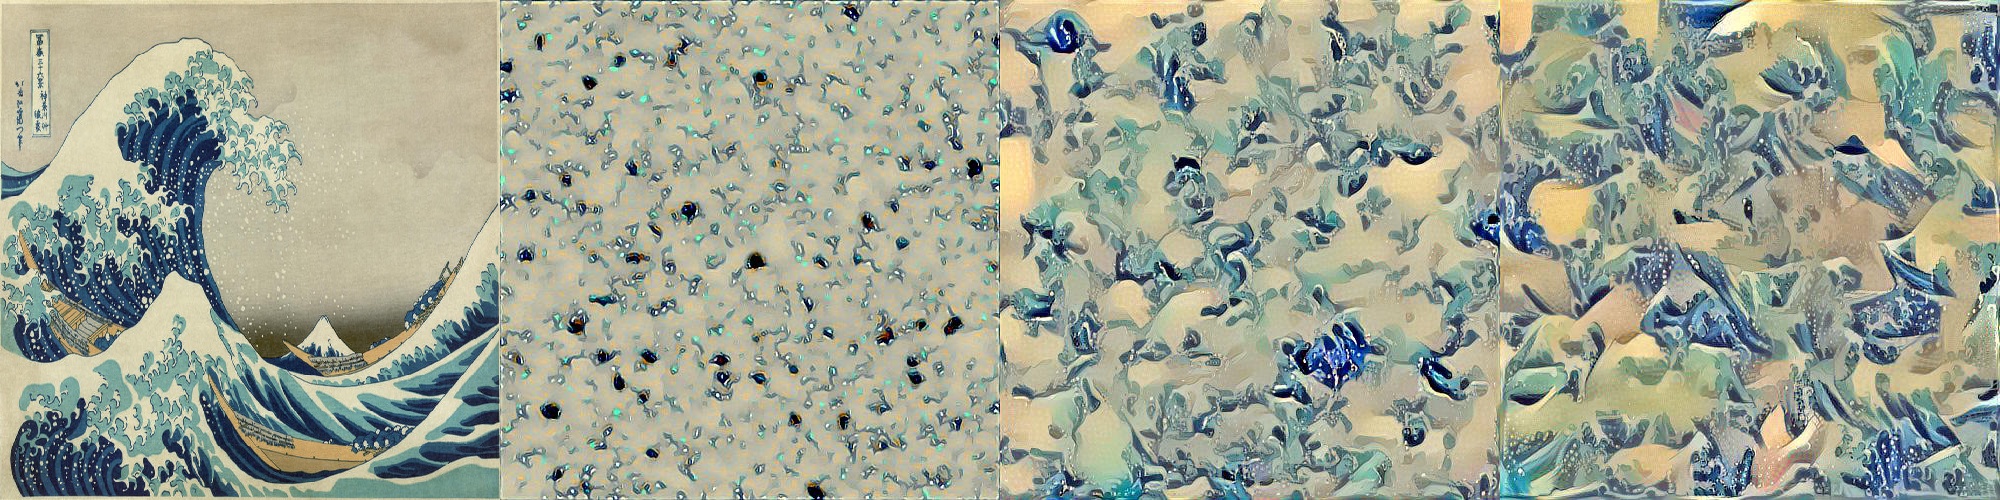

In [39]:
combined = Image.new("RGB", (IMAGE_WIDTH*4, IMAGE_HEIGHT))
combined_path = "style_reconstruct.jpg"
x_offset = 0
for image in map(Image.open, [style_path] + outs):
    image = image.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_path)
combined